In [1]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys         
sys.path.append('./../../')  
from src.signals.BaseSignal import BaseSignal
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from pathlib import Path
import random
from copy import deepcopy
import os
import shutil
from itertools import groupby
from operator import itemgetter

In [3]:
path = 'mimic_db/p00/p000735/3189254_0006'

In [4]:
data, info = wfdb.rdsamp(path)

In [6]:
info

{'fs': 125,
 'sig_len': 731375,
 'n_sig': 6,
 'base_date': None,
 'base_time': datetime.time(19, 50, 49, 600000),
 'units': ['NU', 'pm', 'mV', 'mV', 'mV', 'mmHg'],
 'sig_name': ['PLETH', 'RESP', 'II', 'V', 'AVR', 'ABP'],
 'comments': []}

In [5]:
data

array([[ 2.40273705,  1.        ,  0.98486328,  1.09472656,  0.26513672,
                nan],
       [ 2.40273705,  1.        ,  0.95507812,  1.07470703,  0.30517578,
                nan],
       [ 2.40175953,  1.        ,  0.98486328,  1.13964844,  0.18505859,
                nan],
       ...,
       [ 1.8514174 ,  0.32934278,  0.96972656,  0.85498047,  0.13525391,
        67.11179927],
       [ 1.91104594,  0.3283655 ,  0.88476562,  0.875     ,  0.24511719,
        67.25833158],
       [ 1.98044966,  0.3283655 ,  0.89501953,  0.90478516,  0.23486328,
        67.30717569]])

In [2]:
FS = 125
MAX_SAMPLES_PER_SUBJECT = 30
SAMPLE_LEN_SEC = 120
SAMPLE_LEN_SAMPLES = SAMPLE_LEN_SEC * FS

In [3]:
class MultiSignal:
    def __init__(self, name, ecg, ppg, abp):
        self.ecg = ecg
        self.ppg = ppg
        self.abp = abp
        self.duration = self.ecg.duration
        self.signals = [self.ecg, self.ppg, self.abp]
        
    def plot(self, start_time=0, width=10, scatter=False, line=True, first_der=False):
        fig, axes = plt.subplots(3, 1, figsize=(24, 15))
        for signal, ax in zip(self.signals, axes):
            signal.plot(start_time, width, scatter, line, first_der, ax=ax)
        plt.tight_layout()

def create_multisignal(path):
    data, info = wfdb.rdsamp(f'mimic_db/{path}')
    fs = info['fs']
    sig_names = info['sig_name']
    
    ecg_signal = BaseSignal("ECG", data[:, sig_names.index("II")], fs)
    ppg_signal = BaseSignal("PPG", data[:, sig_names.index("PLETH")], fs)    
    abp_signal = BaseSignal("ABP", data[:, sig_names.index("ABP")], fs) 
    
    measurement_path = path.split("/")[-1]
    return MultiSignal(measurement_path, ecg_signal, ppg_signal, abp_signal)

def validate(path):
    try:
        data, info = wfdb.rdsamp(f'mimic_db/{path}')
        df = pd.DataFrame(data, columns=info['sig_name'])
        if any(sig_name not in info['sig_name'] for sig_name in ['ABP', 'II', 'PLETH']):
            return False
        abp_nans = np.isnan(df['ABP'].values).sum()
        ppg_nans = np.isnan(df['PLETH'].values).sum()
        ecg_nans = np.isnan(df['II'].values).sum()

        is_nans_good = all([nans / len(df) < 0.95 for nans in [abp_nans, ppg_nans, ecg_nans]])

        return is_nans_good
    except Exception:
        print(f"{path} failed")
        return False
    
def remove_measurements(measurements):
    for path in tqdm(measurements, desc="Removing invalid measurements"):
        try:
            dir_path = f"mimic_db/{path}"
            os.remove(f"{dir_path}.hea")
            os.remove(f"{dir_path}.dat")
            shutil.rmtree(dir_path)
            with open("removed_measurements.txt", "a") as file:
                file.write(f"{dir_path}\n")
        except Exception as e:
            print(dir_path, f" failed ({e})")

def find_repeats(arr, min_n_repeats):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""
    condition = np.concatenate((arr[:-1] == arr[1:], np.array([False])))
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return [segment.tolist() for segment in idx if (segment[1] - segment[0]) >= min_n_repeats - 1]

def validate_signal(data, low=None, high=None, n_same=10, min_good_samps=60, buffor=0):
    if len(data) < min_good_samps:
        return np.zeros_like(data) == 1
    
    no_nans = ~np.isnan(data)
    if low is None or high is None:
        good_range = np.zeros_like(data) == 0
    else:
        good_range = (data > low) & (data < high)
    
    different_vals = np.zeros_like(data) == 0
    repeats_bounds = find_repeats(data, n_same)
    for start_idx, end_idx in repeats_bounds:
        different_vals[start_idx : end_idx+1] = False
        
    return no_nans & good_range & different_vals

def validate_recording(abp, ppg, ecg, fs=125, n_same=10, buffor=10, min_good_secs=30):
    min_good_samps = min_good_secs * fs
    abp_is_good = validate_signal(abp, low=0, high=300, n_same=n_same)
    ppg_is_good = validate_signal(ppg, low=None, high=None, n_same=n_same)
    ecg_is_good = validate_signal(ecg, low=None, high=None, n_same=n_same)
    is_good = abp_is_good & ppg_is_good & ecg_is_good
    
    is_good_final = np.copy(is_good)
    if buffor > 0:
        for i, good_samp in enumerate(is_good):
            if not good_samp:
                if i - buffor < 0:
                    start = 0
                else:
                    start = i - buffor
                is_good_final[start:i] = False

                if i + buffor > len(data):
                    end = len(data)
                else:
                    end = i + buffor
                is_good_final[i:end] = False
                
    # is_good = np.copy(is_good_final)
#     if min_good_samps > 0:
#         prev_bad_samp = 0
#         next_bad_samp = 0
#         for i, good_samp in enumerate(is_good):
#             if not good_samp:
#                 if next_bad_samp == 0:
#                     next_bad_samp = i
#                 else:
#                     prev_bad_samp, next_bad_samp = next_bad_samp, i

#                 if prev_bad_samp != 0 and next_bad_samp != 0:
#                     if next_bad_samp - prev_bad_samp < min_good_samps:
#                         is_good_final[prev_bad_samp:next_bad_samp] = False
    return is_good_final

def find_good_segments(abp, ppg, ecg, fs=125, n_same=10, buffor=10, min_good_secs=30):
    is_good = validate_recording(abp, ppg, ecg, fs, n_same, buffor, min_good_secs)
    segments = [(group[0], group[-1]) for group in (list(group) for key, group in groupby(range(len(is_good)), key=is_good.__getitem__) if key)]
    good_segments = [segment for segment in segments if (segment[1] - segment[0]) / fs > min_good_secs]
    return good_segments

def find_valid_segments(path, n_same=10, buffor=0, min_good_secs=120, return_segments=False):
    try:
        data, info = wfdb.rdsamp(f'mimic_db/{path}')
        fs = info['fs']
        sig_names = info['sig_name']

        abp = data[:, sig_names.index("ABP")] 
        ppg = data[:, sig_names.index("PLETH")] 
        ecg = data[:, sig_names.index("II")] 

        valid_segments = find_good_segments(abp, ppg, ecg, fs=FS, n_same=n_same, buffor=buffor, min_good_secs=min_good_secs)
        dir_path = Path("mimic_db") / path
        for start, end in valid_segments:
            segment_path = dir_path / f"{start}-{end}"
            with open("valid_segments.txt", "a") as file:
                file.write(f"{str(segment_path)}\n")
        with open("segmented_measurements.txt", "a") as file:
            file.write(f"{path}\n")
        with open("logs.txt", "a") as file:
            file.write(f"{path} OK ({len(valid_segments)} segments)\n")
        if return_segments:
            return valid_segments
        return True
    except Exception as e:
        with open("logs.txt", "a") as file:
            file.write(f"{path} failed ({e})\n")
        print(f"{path} failed ({e})")
        return False
    
def load_segment_to_df(path, start, end):
    data, info = wfdb.rdsamp(path)
    fs = info['fs']
    sig_names = info['sig_name']
    abp = data[start:end, sig_names.index("ABP")] 
    ppg = data[start:end, sig_names.index("PLETH")] 
    ecg = data[start:end, sig_names.index("II")] 
    return pd.DataFrame({"ABP": abp, "PPG": ppg, "ECG": ecg})

# **Validating measurements**

In [27]:
with open('downloaded_measurements.txt') as f:
    measurements = f.readlines()
    measurements = np.array([path.replace("\n", "") for path in measurements])
    
with open('valid_measurements.txt') as f:
    valid_measurements = f.readlines()
    valid_measurements = np.array([path.replace("\n", "") for path in valid_measurements])
    
measurements_to_validate = np.array([path for path in measurements if path not in valid_measurements])
print(f" Validated {len(valid_measurements)} measurements\n Attempting validation of {len(measurements_to_validate)} measurements..")
valid_records = Parallel(n_jobs=-1)(delayed(validate)(path) for path in tqdm(measurements_to_validate, desc="Validating measurements"))
valid_measurements = np.concatenate((valid_measurements, measurements_to_validate[valid_records]))

textfile = open("valid_measurements.txt", "w")
for measurement_path in valid_measurements:
    textfile.write(measurement_path + "\n")
textfile.close()

unique_subjects = np.unique([m.split("/")[1] for m in valid_measurements])
len(unique_subjects)

 Validated 139707 measurements
 Attempting validation of 4243 measurements..


Validating measurements:   0%|          | 0/4243 [00:00<?, ?it/s]

p00/p000543/3047369_0024 failed
p00/p001190/3517614_0038 failed
p00/p001501/3016830_0007 failed
p00/p001501/3016830_0017 failed
p00/p001501/3016830_0061 failed
p00/p001501/3016830_0093 failed
p00/p001501/3137532_0063 failed
p00/p001855/3394564_0041 failed
p00/p001855/3394564_0043 failed
p00/p001855/3394564_0068 failed
p00/p001855/3394564_0069 failed
p00/p001855/3394564_0100 failed
p00/p001855/3394564_0101 failed
p00/p001855/3394564_0102 failed
p00/p001855/3394564_0103 failed
p00/p002513/3814737_0011 failed
p00/p002586/3757068_0001 failed
p00/p002586/3757068_0016 failed
p00/p002906/3269656_0050 failed
p00/p004324/3360469_0020 failed
p00/p004324/3360469_0021 failed
p00/p004324/3360469_0022 failed
p00/p004324/3360469_0023 failed
p00/p004324/3360469_0024 failed
p00/p004324/3360469_0025 failed
p00/p004324/3360469_0026 failed
p00/p004324/3360469_0027 failed
p00/p008698/3538091_0037 failed
p00/p008698/3538091_0040 failed
p00/p008698/3538091_0041 failed
p00/p008723/3083615_0002 failed
p00/p008

2195

# **Segmenting measurements**

In [29]:
with open('segmented_measurements.txt') as f:
    segmented_measurements = f.readlines()
    segmented_measurements = [path.replace("\n", "") for path in segmented_measurements]
    
measurements_to_segment = [path for path in valid_measurements if path not in segmented_measurements]
print(f" Segmented {len(segmented_measurements)} measurements\n Attempting segmentation of {len(measurements_to_segment)} measurements..")
segmented_measurements = Parallel(n_jobs=-1)(delayed(find_valid_segments)(path) for path in tqdm(measurements_to_segment, desc="Segmenting measurements"))

 Segmented 114978 measurements
 Attempting segmentation of 24764 measurements..


Segmenting measurements:   0%|          | 0/24764 [00:00<?, ?it/s]

p06/p068127/3590234_0059 failed
p06/p068268/3723858_0002 failed
p06/p068299/3621239_0014 failed
p06/p068300/3114114_0002 failed
p06/p068356/3251415_0522 failed
p06/p068391/3523293_0060 failed
p06/p068391/3523293_0087 failed
p06/p068391/3523293_0077 failed
p06/p068396/3168399_0021 failed
p06/p068396/3168399_0114 failed
p06/p068425/3045916_0039 failed
p06/p068426/3242404_0006 failed
p06/p068453/3725200_0015 failed
p06/p068475/3047843_0003 failed
p06/p068475/3047843_0006 failed
p06/p068475/3047843_0007 failed
p06/p068475/3205707_0005 failed
p06/p068475/3205707_0008 failed
p06/p068475/3205707_0006 failed
p06/p068475/3205707_0012 failed
p06/p068475/3205707_0011 failed
p06/p068475/3205707_0013 failed
p06/p068475/3205707_0017 failed
p06/p068475/3205707_0015 failed
p06/p068475/3205707_0019 failed
p06/p068475/3205707_0021 failed
p06/p068475/3205707_0023 failed
p06/p068475/3205707_0025 failed
p06/p068475/3205707_0022 failed
p06/p068475/3205707_0028 failed
p06/p068475/3205707_0031 failed
p06/p068

# **Removing invalid measurements**

In [82]:
downloaded_measurements = pd.read_csv("downloaded_measurements.txt", names=['path'])['path'].values
removed_measurements = pd.read_csv("removed_measurements.txt", names=['path'])['path'].values
removed_measurements = ["/".join(path.split("/")[1:]) for path in removed_measurements]

valid_segments = pd.read_csv("valid_segments.txt", names=['path'])
valid_measurements = np.unique(["/".join(path.split("/")[1:-1]) for path in valid_segments['path'].values])
measurements_to_remove = [measurement for measurement in downloaded_measurements if measurement not in valid_measurements and measurement not in removed_measurements]
# remove_measurements(measurements_to_remove)

/tmp/ipykernel_5924/1159310401.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  measurements_to_remove = [measurement for measurement in downloaded_measurements if measurement not in valid_measurements and measurement not in removed_measurements]


# **Creating dataset**

In [14]:
def get_records_samples_bounds(records_bounds, sample_len_samples, shuffle_segments=True):
    records_samples_bounds = {}
    for record, record_bounds in records_bounds.items():
        record_segments_bounds = []
        for start, end in record_bounds:
            segment_start = start
            segment_end = start + sample_len_samples
            while segment_end < end:
                record_segments_bounds.append((segment_start, segment_end))
                segment_start, segment_end = segment_end, segment_end + SAMPLE_LEN_SAMPLES
        records_samples_bounds[record] = record_segments_bounds
    if shuffle_segments:
        for record, segments_bounds in records_samples_bounds.items():
            random.shuffle(segments_bounds)
    return records_samples_bounds

def cut_segments_for_subjects(subjects, subjects_records, records_bounds, max_samples_per_subject, sample_len_samples):
    samples_bounds = get_records_samples_bounds(records_bounds, sample_len_samples)
    subjects_data = {}
    
    for subject in tqdm(subjects, desc="Cutting subjects recordings into segments"):
        n_samples = 0
        record_idx = 0
        subject_records = subjects_records[subject]
        subject_data = []
        while n_samples < max_samples_per_subject:
            current_record = subject_records[record_idx]
            record_path = f"{subject}/{current_record}"
            possible_segments_bounds = samples_bounds[record_path]
            try:
                sample_start_idx, sample_end_idx = possible_segments_bounds.pop()
            except:
                break # no more samples
            sample_path = f"{record_path}/{sample_start_idx}-{sample_end_idx}"
            if sample_path not in subject_data:
                subject_data.append({'path': record_path, 'start': sample_start_idx, 'end': sample_end_idx})
            n_samples += 1
            record_idx += 1
            if record_idx > len(subject_records) - 1:
                record_idx = 0
        subjects_data[subject] = subject_data
    return subjects_data

def create_dataset(valid_segments, max_samples_per_subject, sample_len_samples, seed=42):
    subjects = np.unique(["/".join(m['path'].split("/")[1:3]) for m in valid_segments])
    print(f" Found {len(subjects)} unique subjects")
    records = np.unique(["/".join(segment['path'].split('/')[1:]) for segment in valid_segments])
    print(f" Found {len(records)} valid records with total of {len(valid_segments)} valid segments")
    records_bounds = {"/".join(record.split("/")[1:]): [(segment['start'], segment['end']) for segment in segments] for record, segments in groupby(valid_segments, key = itemgetter('path'))}
    subjects_segments = {subject: [segment for segment in valid_segments if subject in segment['path']] for subject in subjects}
    subjects_records = {subject: np.unique([segment['path'].split("/")[3] for segment in segments]).tolist() for subject, segments in subjects_segments.items()}
    
    print(f" Segments cutting in progress..")
    random.seed(seed)
    subjects_datataset_info = cut_segments_for_subjects(subjects, subjects_records, records_bounds, MAX_SAMPLES_PER_SUBJECT, SAMPLE_LEN_SAMPLES)
    
    with open("samples_segmentation_info.txt", "a") as file:
        file.write("sample,segment\n")
        
    def save_sample_to_csv(i, subject, sample):
        try:
            path, start, end = sample['path'], sample['start'], sample['end']
            subject = path.split("/")[1]
            path = f'mimic_db/{path}'
            df = load_segment_to_df(path, start, end)
            df.to_csv(f"mimic_csv/{subject}_{i}.csv", index=False)
            with open("info_120s.txt", "a") as file:
                file.write(f"{subject}_{i},{path}/{start}-{end}\n")
            return True
        except Exception as e:
            print(f"{i}, {sample} failes")
            return False
        
    for subject, samples in tqdm(subjects_datataset_info.items(), desc=f"Saving subjects segments into csv files ({SAMPLE_LEN_SEC}s samples)"):
        saved_samples = Parallel(n_jobs=4)(delayed(save_sample_to_csv)(i, subject, sample) for i, sample in enumerate(samples))

In [15]:
with open('valid_segments.txt') as f:
    valid_segments = f.readlines()
    valid_segments = np.array([path.replace("\n", "") for path in valid_segments])

valid_segments = [{'path': "/".join(segment.split("/")[:-1]), 'start': int(segment.split("/")[-1].split("-")[0]), 'end': int(segment.split("/")[-1].split("-")[1])} for segment in valid_segments]

In [16]:
create_dataset(valid_segments, MAX_SAMPLES_PER_SUBJECT, SAMPLE_LEN_SAMPLES, seed=42)

 Found 1677 unique subjects
 Found 24385 valid records with total of 353646 valid segments
 Segments cutting in progress..


Cutting subjects recordings into segments:   0%|          | 0/1677 [00:00<?, ?it/s]

Saving subjects segments into csv files (120s samples):   0%|          | 0/1677 [00:00<?, ?it/s]

In [43]:
seg_info = pd.read_csv("samples_segmentation_info.txt")
fs = np.array([FS]*len(seg_info))
samples_path = np.array([f"{sample}.csv" for sample in seg_info['sample']])
subjects = np.array([sample.split("_")[0] for sample in seg_info['sample']])
subjects_sample_number = np.array([int(sample.split("_")[1]) for sample in seg_info['sample']])
recording_path = np.array(["/".join(segment_path.split("/")[1:-1]) for segment_path in seg_info['segment']])
samples_start_idxs = np.array([int(sample.split("/")[-1].split("-")[0]) for sample in seg_info['segment']])
samples_end_idxs = np.array([int(sample.split("/")[-1].split("-")[1]) for sample in seg_info['segment']])

dataset_info = pd.DataFrame({
    "sample_path": samples_path,
    "subject": subjects,
    "sample_num": subjects_sample_number,
    "recording": recording_path,
    "sample_start_idx": samples_start_idxs,
    "sample_end_idx": samples_end_idxs,
    "fs": fs
}).sort_values(["subject", "sample_num"]).reset_index(drop=True)
dataset_info.to_csv("dataset_info.csv", index=False)

<AxesSubplot:ylabel='Count'>

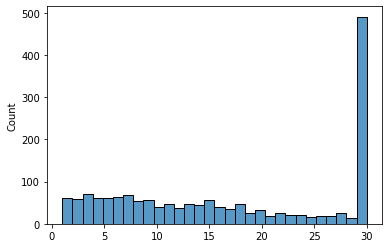

In [33]:
sns.histplot(dataset_info.value_counts('subject'), bins=30)